In [6]:
!pip install mtcnn

import os
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, BatchNormalization
import cv2
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from skimage.transform import resize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.svm import SVC
from skimage.transform import resize
import pickle

     |████████████████████████████████| 2.3 MB 8.3 MB/s 


In [ ]:
#Folder that contains face_extracted images
face_detect_folder = '/content/drive/MyDrive/AI4E_Data/FaceDetectionData'

X_data = []
Y_data = []

# stop = 0
for filename in os.listdir(face_detect_folder):
    # if(stop == 10):
    #   break
    if filename.endswith('jpg'):
      image = plt.imread(os.path.join(face_detect_folder,filename))
      X_data.append(image)
      #extract name without .jpg
      name_wo_mp4 = filename[:len(filename) - 4]

      #extract person name
      pattern = r'[0-9]'
      name = re.sub(pattern, '', name_wo_mp4)
      #xoa space
      name.replace(" ", "")
      Y_data.append(name)

len(X_data)

5748

In [ ]:
#chia train/val/test
X_np_data = np.array(X_data)
Y_np_data = np.array(Y_data)

X_train, X_val, y_train, y_val = train_test_split(X_np_data, Y_np_data, test_size=0.2, stratify =Y_np_data)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify =y_val)

print(len(X_train))
print(len(X_val))
print(len(X_test))

4598
575
575


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
#resize image to fit input of pretrain model
def resize_image(X):
  res = []
  for i in range(len(X)):
    res.append(cv2.resize(X[i],(160,160),interpolation = cv2.INTER_AREA))
  res = np.array(res)
  return res

In [ ]:
X_train_resize = resize_image(X_train)
X_val_resize = resize_image(X_val)
X_test_resize = resize_image(X_test)

In [ ]:
#Normalize to range (0,1)
X_train_norm = X_train_resize/255.
X_val_norm = X_val_resize/255.
X_test_norm = X_test_resize/255.

In [ ]:
X_train_norm.shape

(4598, 160, 160, 3)

In [ ]:
#Encode y
le = preprocessing.LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_val_le = le.fit_transform(y_val)
y_test_le = le.fit_transform(y_test)

In [ ]:
name_map ={}
for i in range(14):
  for j in range(len(y_test_le)):
    if y_test_le[j] == i:
      print(y_test[j])
      print(y_test_le[j])
      name_map[y_test_le[j]] = y_test[j]
      break
print(name_map)

Hiếu
0
Hùng
1
HĐức
2
Kiên
3
Linh
4
Quân
5
Tân
6
Thắng
7
Trường
8
Tuấn
9
Vân
10
Việt Đức
11
Xuân Anh
12
Đức
13
{0: 'Hiếu', 1: 'Hùng', 2: 'HĐức', 3: 'Kiên', 4: 'Linh', 5: 'Quân', 6: 'Tân', 7: 'Thắng', 8: 'Trường', 9: 'Tuấn', 10: 'Vân', 11: 'Việt Đức', 12: 'Xuân Anh', 13: 'Đức'}


In [ ]:
#Load pretrained model and weight
#Using Facenet
model_path = '/content/drive/MyDrive/keras-facenet/model/facenet_keras.h5'
weight_path = '/content/drive/MyDrive/keras-facenet/weights/facenet_keras_weights.h5' 
facenet = load_model(model_path)
facenet.load_weights(weight_path)

In [ ]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [ ]:
def calc_embs(filepaths, margin=10, batch_size=1):
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(facenet.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [ ]:
embs = facenet.predict(X_train_norm)

Cause: could not parse the source code of <function <lambda> at 0x7f4096c01b90>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f4096c01b90>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f4096c01dd0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f4096c01dd0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f4096c01ef0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could no

In [ ]:
embs_norm = l2_normalize(embs)

In [ ]:
clf = SVC(kernel='linear', probability=True).fit(embs, y_train_le)

In [ ]:
val_embs = facenet.predict(X_val_norm)

In [ ]:
clf.score(val_embs, y_val_le)

0.9947826086956522

In [ ]:
test_embs = facenet.predict(X_test_norm)

In [ ]:
clf.score(test_embs, y_test_le)

0.9895652173913043

In [ ]:
filename = '/content/drive/MyDrive/AI4E_Data/svm.sav'
# pickle.dump(clf, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.score(test_embs, y_test_le)

0.9930434782608696

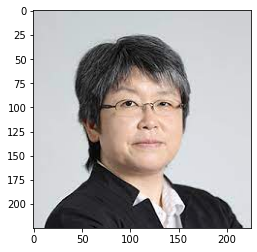

In [ ]:
img_path = '/content/drive/MyDrive/AI4E_Data/CW2TestData/images.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
#extract face from image
def crop_face_image(image_path):
  detector = MTCNN()
  # if type(image_path) == str:
  #   img = cv2.imread(image_path)
  # else:
  #   img = image_path
  img = cv2.imread(image_path)
  data = detector.detect_faces(img)
  #in case we detected multiple faces, then choose the biggest one
  biggest = 0
  if data != []:
    for faces in data:
      box = faces['box']
      #calculate the are in the image
      #box[0] =x, box[1] = y, box[2] = width, box[3] = height
      #but (x,y) here is center point or upper left point?
      #i think its upper left point
      area = box[3] *box[2]
      if area > biggest:
        biggest = area
        bbox = box
    bbox[0] = 0 if bbox[0] < 0 else bbox[0]
    bbox[1] = 0 if bbox[1] < 0 else bbox[1]
    img = img[bbox[1] : bbox[1] + bbox[3], bbox[0] : bbox[0] + bbox[2]]
    #convert from bgr to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return (True, img)
  else:
    return (False, None)

<Figure size 432x288 with 0 Axes>

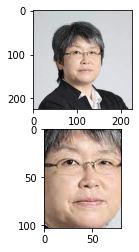

In [ ]:
#Extract face from image
status, image = crop_face_image(img_path)
if status:
  plt.figure()
  f, axarr = plt.subplots(2,1) 
  orig_img = plt.imread(img_path)
  axarr[0].imshow(orig_img)
  axarr[1].imshow(image)

  plt.imshow(image)
else:
  print('No facial image was detected')

In [ ]:
#Preprocess Image
image = cv2.resize(image,(160,160),interpolation = cv2.INTER_AREA)
image = image/255.

In [ ]:
#Predict
#Write the true name
true_name='Unknown'
#Expand dims to have valid shape for keras model prediction
image_exdim = np.expand_dims(image, axis =0)
embs_pred = facenet.predict(image_exdim)




In [ ]:
pred = loaded_model.predict(embs_pred)

In [ ]:
name_map[pred[0]]

'Kiên'

In [ ]:
np.max(clf.predict_proba(embs_pred))

0.5381705595387327

In [ ]:
test_pred = loaded_model.predict(test_embs)
#take a list of wrong prediction image 'indexes
wrong_pred_index =[]
for i in range(len(test_pred)):
  if test_pred[i]  != y_test_le[i] :
      wrong_pred_index.append(i)
print(len(wrong_pred_index))

4


In [ ]:
thres = 0.75

In [ ]:
wrong = clf.predict_proba(test_embs[wrong_pred_index])

In [ ]:
for prob in wrong:
  print(np.max(prob))

0.3683637186535253
0.6734887224284524
0.6391657945327406
0.26947939772152174


#Prediction

In [7]:
model_path = '/content/drive/MyDrive/keras-facenet/model/facenet_keras.h5'
weight_path = '/content/drive/MyDrive/keras-facenet/weights/facenet_keras_weights.h5' 
facenet = load_model(model_path)
facenet.load_weights(weight_path)

In [27]:
folder_path ='/content/drive/MyDrive/AI4E_Data/CW2TestData'


In [20]:
def crop_face_image(image_path):
  detector = MTCNN()
  # if type(image_path) == str:
  #   img = cv2.imread(image_path)
  # else:
  #   img = image_path
  img = cv2.imread(image_path)
  data = detector.detect_faces(img)
  #in case we detected multiple faces, then choose the biggest one
  biggest = 0
  if data != []:
    for faces in data:
      box = faces['box']
      #calculate the are in the image
      #box[0] =x, box[1] = y, box[2] = width, box[3] = height
      #but (x,y) here is center point or upper left point?
      #i think its upper left point
      area = box[3] *box[2]
      if area > biggest:
        biggest = area
        bbox = box
    bbox[0] = 0 if bbox[0] < 0 else bbox[0]
    bbox[1] = 0 if bbox[1] < 0 else bbox[1]
    img = img[bbox[1] : bbox[1] + bbox[3], bbox[0] : bbox[0] + bbox[2]]
    #convert from bgr to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return (True, img)
  else:
    return (False, None)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
image_list = []
label_list = []
# stop = 0
for filename in os.listdir(folder_path):
    # if(stop == 10):
    #   break
    if filename.endswith('jpg'):
      img_path = os.path.join(folder_path, filename)
      status, image = crop_face_image(img_path)
      if status:
        print('Extract Face Ok')
        image_list.append(image)
        #extract name without .jpg
        name_wo_mp4 = filename[:len(filename) - 4]

        #extract person name
        pattern = r'[0-9]'
        name = re.sub(pattern, '', name_wo_mp4)
        #xoa space
        name.replace(" ", "")
        label_list.append(name)
        # stop += 1
      else:
        print('No facial image was detected')

len(image_list)

Extract Face Ok
Extract Face Ok
Extract Face Ok
Extract Face Ok
Extract Face Ok
Extract Face Ok
Extract Face Ok
Extract Face Ok
Extract Face Ok
Extract Face Ok
Extract Face Ok


11

In [22]:
svm_model = '/content/drive/MyDrive/AI4E_Data/svm.sav'

In [13]:
loaded_model = pickle.load(open(svm_model, 'rb'))

In [14]:
#resize image to fit input of pretrain model
def resize_image(X):
  res = []
  for i in range(len(X)):
    res.append(cv2.resize(X[i],(160,160),interpolation = cv2.INTER_AREA))
  res = np.array(res)
  return res

In [29]:
image_list = resize_image(image_list)
image_list = image_list/255.

In [24]:
label_list[2]

'Hiếu'

In [17]:
#Load name_map
name_map ={0: 'Hiếu', 1: 'Hùng', 2: 'HĐức', 3: 'Kiên', 4: 'Linh', 5: 'Quân', 6: 'Tân', 7: 'Thắng', 8: 'Trường', 9: 'Tuấn', 10: 'Vân', 11: 'Việt Đức', 12: 'Xuân Anh', 13: 'Đức'}

In [30]:
#Predict
#Write the true name
thres = 0.7
pred_embs = facenet.predict(image_list)
name_pred= loaded_model.predict_proba(pred_embs)

for i in range(len(name_pred)):
  if np.max(name_pred[i]) > thres:
    print('Truth: ', label_list[i], ' Predict: ', name_map[np.argmax(name_pred[i])])
  else:
    print('Truth: ', label_list[i], ' Predict: ', 'Unknown')

Truth:  Đức  Predict:  Đức
Truth:  HĐức  Predict:  HĐức
Truth:  Hiếu  Predict:  Hiếu
Truth:  Hùng  Predict:  Hùng
Truth:  Kiên  Predict:  Unknown
Truth:  asas  Predict:  Đức
Truth:  michael park__fc-crop  Predict:  Unknown
Truth:  images  Predict:  Kiên
Truth:  young-asian-man-face-isolated-white-closeup-  Predict:  Unknown
Truth:  download  Predict:  Tân
Truth:  -asian-handsome-man-smiling-and-laughing-isolated-on-white-background-soft-focus  Predict:  HĐức


In [32]:
np.max(name_pred[10])

0.9856279680553826